# Проект
### Анализ спроса и факторов бестселлеров маркетплейса
Цель проекта — проанализировать факторы, связанные с уровнем спроса и статусом бестселлера товаров на маркетплейсе Amazon.

В рамках проекта рассмотрим следующие вопросы:
- Как распределены цены и спрос на товары Amazon?
- Чем бестселлеры отличаются от обычных товаров?
- Можно ли по доступным признакам предсказать, станет ли товар бестселлером?
  
Входные данные - открытые данные Amazon (1,4 млн. товаров) Kaggle, включающие:
* amazon_categories.csv - файл с информацией о категориях;
* amazon_products.csv - файл с информацией о товарах, включает название, количество отзывов, рейтинг, цена, скидка и данные о продажах за 2023 год.

In [236]:
import kagglehub
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [237]:
# Зададим параметры для визуализации графиков по умолчанию
sns.set(font_scale = 1, style = "whitegrid", rc ={'figure.figsize':(10, 7)})

## 1. Загрузка и первичная обработка данных
На первом этапе загрузим данныеемаркетплейса с использованием Kaggle API и  выполима проверуа структуры данных, типов признаков и наличия пропусков, 
а такжсделаем е базуюая предобрабоука, необходуюая для последующего анализа.

In [239]:
# загрузим данные с Kaggle через библиотеку kagglehub, которая позволяет работать с Kaggle API
path= kagglehub.dataset_download('asaniczka/amazon-products-dataset-2023-1-4m-products')
csv_path_category= Path(path) / 'amazon_categories.csv'
csv_path_products= Path(path) / 'amazon_products.csv'

In [240]:
# Загружаем файл с категориями
df_categories= pd.read_csv(csv_path_category)

Рассмотрим данные: размер датасета, наличие пропусков и дублей, типы данных и количество уникальных значений.

In [242]:
df_categories.head()

,id,category_name
0,1,Beading & Jewelry Making
1,2,Fabric Decorating
2,3,Knitting & Crochet Supplies
3,4,Printmaking Supplies
4,5,Scrapbooking & Stamping Supplies


In [243]:
# размер датасета
df_categories.shape

(248, 2)

In [244]:
# узнаем типы данных
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             248 non-null    int64 
 1   category_name  248 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [245]:
# проверим количество незаполненных значений 
df_categories.isna().sum()

id               0
category_name    0
dtype: int64

In [246]:
# проверим наличие дубликатов 
df_categories.duplicated().sum()

0

In [247]:
# количество уникальных значений
df_categories.nunique()

id               248
category_name    248
dtype: int64

In [248]:
# прочитаем название колонок
pd.read_csv(csv_path_products, nrows=0).columns


Index(['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price',
       'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth'],
      dtype='object')

In [249]:
# посомтрим на размер датафрейма и загрузим CSV файл порциями по 100_000 строк
for chunk in pd.read_csv(csv_path_products, chunksize=100000):
    print(chunk.shape) 

(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(100000, 11)
(26337, 11)


In [250]:
# загрузим только нужные для анализа данные
df_products= pd.read_csv(
    csv_path_products, usecols=['asin', 'title', 'stars', 'reviews', 'price','listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth'])
df_products.shape

(1426337, 9)

In [251]:
df_products.head()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,0.00,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,209.99,104,False,1000
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,429.99,104,False,300
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,354.37,104,False,400
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,309.99,104,False,400


In [252]:
# узнаем типы данных
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426337 entries, 0 to 1426336
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   asin               1426337 non-null  object 
 1   title              1426336 non-null  object 
 2   stars              1426337 non-null  float64
 3   reviews            1426337 non-null  int64  
 4   price              1426337 non-null  float64
 5   listPrice          1426337 non-null  float64
 6   category_id        1426337 non-null  int64  
 7   isBestSeller       1426337 non-null  bool   
 8   boughtInLastMonth  1426337 non-null  int64  
dtypes: bool(1), float64(3), int64(3), object(2)
memory usage: 88.4+ MB


In [253]:
# проверим количество незаполненных значений 
df_products.isna().sum()

asin                 0
title                1
stars                0
reviews              0
price                0
listPrice            0
category_id          0
isBestSeller         0
boughtInLastMonth    0
dtype: int64

In [254]:
# датафрейме с категориями переименуем колонку "id" в "category_id"
df_categories= df_categories.rename(columns={'id':'category_id'})

In [255]:
# Объединим датафрейм с информацией о категориях по колонке"category_id"
df_products_v_cat= df_products.merge(df_categories, how='inner', on='category_id')
df_products_v_cat.head()

,asin,title,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,0.00,104,False,2000,Suitcases
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,209.99,104,False,1000,Suitcases
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,429.99,104,False,300,Suitcases
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,354.37,104,False,400,Suitcases
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,309.99,104,False,400,Suitcases


In [256]:
# проверим размер и типы нового датафрейма
df_products_v_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426337 entries, 0 to 1426336
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   asin               1426337 non-null  object 
 1   title              1426336 non-null  object 
 2   stars              1426337 non-null  float64
 3   reviews            1426337 non-null  int64  
 4   price              1426337 non-null  float64
 5   listPrice          1426337 non-null  float64
 6   category_id        1426337 non-null  int64  
 7   isBestSeller       1426337 non-null  bool   
 8   boughtInLastMonth  1426337 non-null  int64  
 9   category_name      1426337 non-null  object 
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 99.3+ MB


In [257]:
# заменим пустое значение наименования на "Untitled"
df_products_v_cat['title'] = df_products_v_cat['title'].fillna('Untitled')

In [258]:
# копируем датафрейм
df= df_products_v_cat.copy()
df.shape

(1426337, 10)

In [259]:
# посмотрим на статистические показатели данных
df.describe()

,stars,reviews,price,listPrice,category_id,boughtInLastMonth
count,1.426337e+06,1.426337e+06,1.426337e+06,1.426337e+06,1.426337e+06,1.426337e+06
mean,3.999512e+00,1.807508e+02,4.337540e+01,1.244916e+01,1.237409e+02,1.419823e+02
std,1.344292e+00,1.761453e+03,1.302893e+02,4.611198e+01,7.311273e+01,8.362720e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.100000e+00,0.000000e+00,1.199000e+01,0.000000e+00,6.500000e+01,0.000000e+00
50%,4.400000e+00,0.000000e+00,1.995000e+01,0.000000e+00,1.200000e+02,0.000000e+00
75%,4.600000e+00,0.000000e+00,3.599000e+01,0.000000e+00,1.760000e+02,5.000000e+01
max,5.000000e+00,3.465630e+05,1.973181e+04,9.999900e+02,2.700000e+02,1.000000e+05


In [260]:
# почитаем количество уникальных значений в каждом столбце датафрейма
df.nunique()

asin                 1426337
title                1385430
stars                     41
reviews                11861
price                  29961
listPrice              14518
category_id              248
isBestSeller               2
boughtInLastMonth         30
category_name            248
dtype: int64

In [261]:
# проверим наличие дубликатов в датафрейме
df.duplicated().sum()

0

In [262]:
# посмотрим на статистические показатели цены
df.price.describe()

count    1.426337e+06
mean     4.337540e+01
std      1.302893e+02
min      0.000000e+00
25%      1.199000e+01
50%      1.995000e+01
75%      3.599000e+01
max      1.973181e+04
Name: price, dtype: float64

In [263]:
# количество продуктов с 0 ценой 
df[df['price'] == 0].asin.count()

32772

In [264]:
# очистим данные от 0 цены, в условиях датасета указано "если 0 значение, цена была недоступна"
df= df[df['price'] > 0]

In [265]:
# посотрим на распределение "бестселлеров"
df['isBestSeller'].value_counts(normalize=True)

isBestSeller
False    0.993923
True     0.006077
Name: proportion, dtype: float64

In [266]:
# категории в которых чаще встречаются бестселлеры
df.groupby('category_name')['isBestSeller'].mean().sort_values(ascending=False).head(10).reset_index()

,category_name,isBestSeller
0,Online Video Game Services,0.333333
1,Tools & Home Improvement,0.140762
2,Sports & Outdoors,0.097422
3,Industrial & Scientific,0.090662
4,Health & Household,0.075630
5,Sports & Fitness,0.072928
6,Smart Home: Other Solutions,0.072000
7,Kitchen & Dining,0.057360
8,Automotive Replacement Parts,0.044393
9,Outdoor Recreation,0.042186


## 2. Разведочный анализ данных (EDA)
В рамках разведочного анализа изучим распределения ключевых метрик (цены, скидки, рейтинга, количества отзывов и спроса), а также выявим характерные особенности данных, уделив особое внимание выявлению потенциальных факторов, связанных со статусом Bestseller.

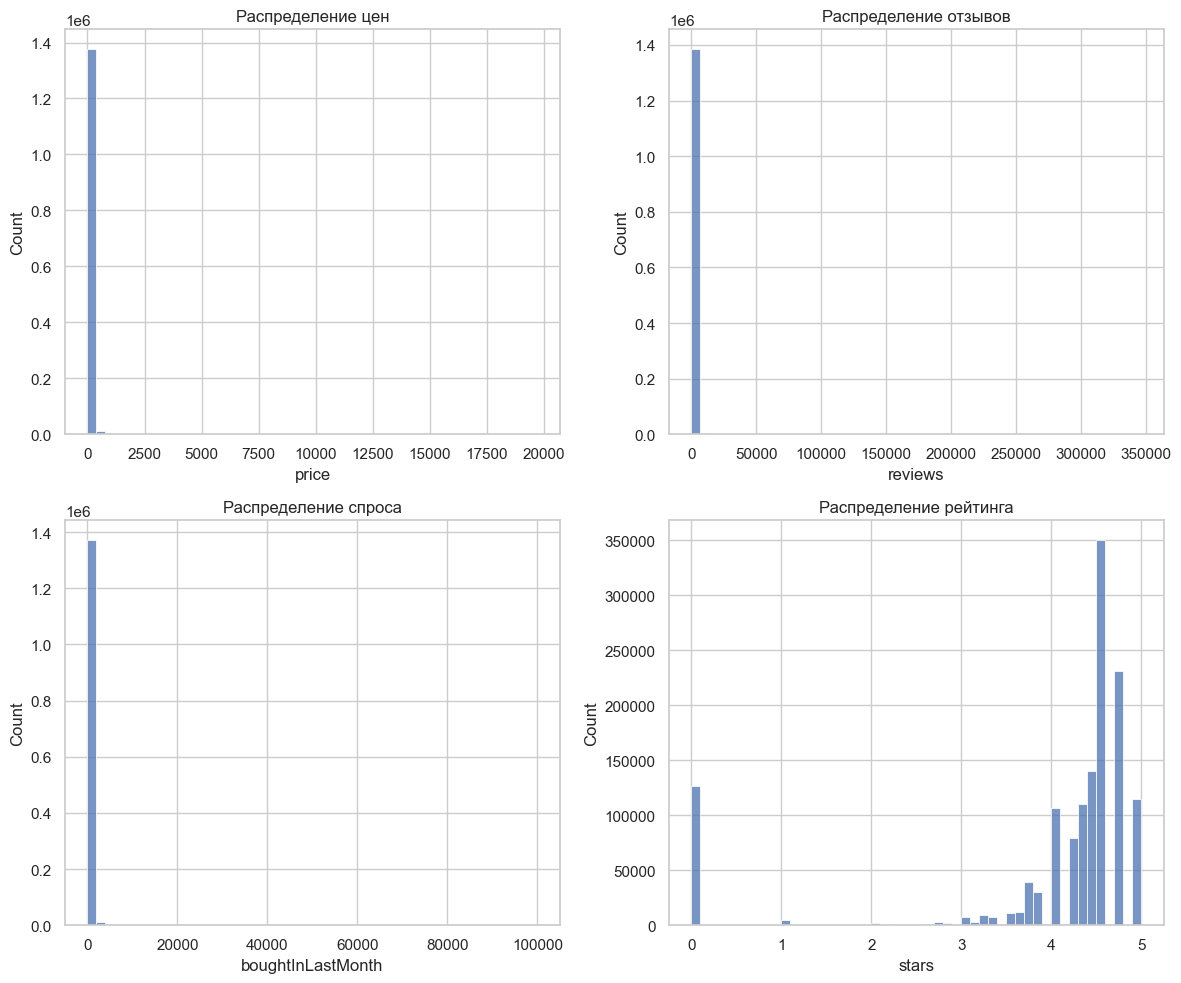

In [349]:
# визуализируем распределение цены, отзывов, спроса и рейтинга
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(data=df, x='price', bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Распределение цен')
sns.histplot(data=df, x='reviews', bins=50, ax=axs[0, 1])
axs[0, 1].set_title('Распределение отзывов')
sns.histplot(data=df, x='boughtInLastMonth', bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Распределение спроса')
sns.histplot(data=df, x='stars', bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Распределение рейтинга')
plt.tight_layout()
plt.show()

Из-за сильной правосторонней асимметрии: большинство товаров имеют цену близкую к нулю, а также не имеют отзывов и спроса - дальнейший анализ корректно проводить в логарифмической шкале.

In [270]:
# посмотрим текущие максимумы распределения продаж и отзывов
df[['boughtInLastMonth', 'reviews']].describe(percentiles=[0.95, 0.99])

,boughtInLastMonth,reviews
count,1.393565e+06,1.393565e+06
mean,1.437882e+02,1.795873e+02
std,8.424829e+02,1.742777e+03
min,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
95%,6.000000e+02,5.310000e+02
99%,2.000000e+03,3.734360e+03
max,1.000000e+05,3.465630e+05


Дополнительно для большей стабильности будущей модели применим "Capping" по 99 перцентилю. Данные пороги выбраны на основе визуального анализа распределений и здравого смысла, чтобы убрать экстремальные значения, которые будут искажать модель.

In [272]:
# для снижения влияния экстремальных значений применим capping по 99 перцентилю (boughtInLastMonth ≤ 2000, reviews ≤ 3735)
df['sales_capped'] = df['boughtInLastMonth'].clip(upper=2000)
df['reviews_capped'] = df['reviews'].clip(upper=3735)


In [273]:
# приводим данные к логарифму
df['log_price'] = np.log1p(df['price'])
df['log_sales'] = np.log1p(df['sales_capped'])
df['reviews_log'] = np.log1p(df['reviews_capped'])

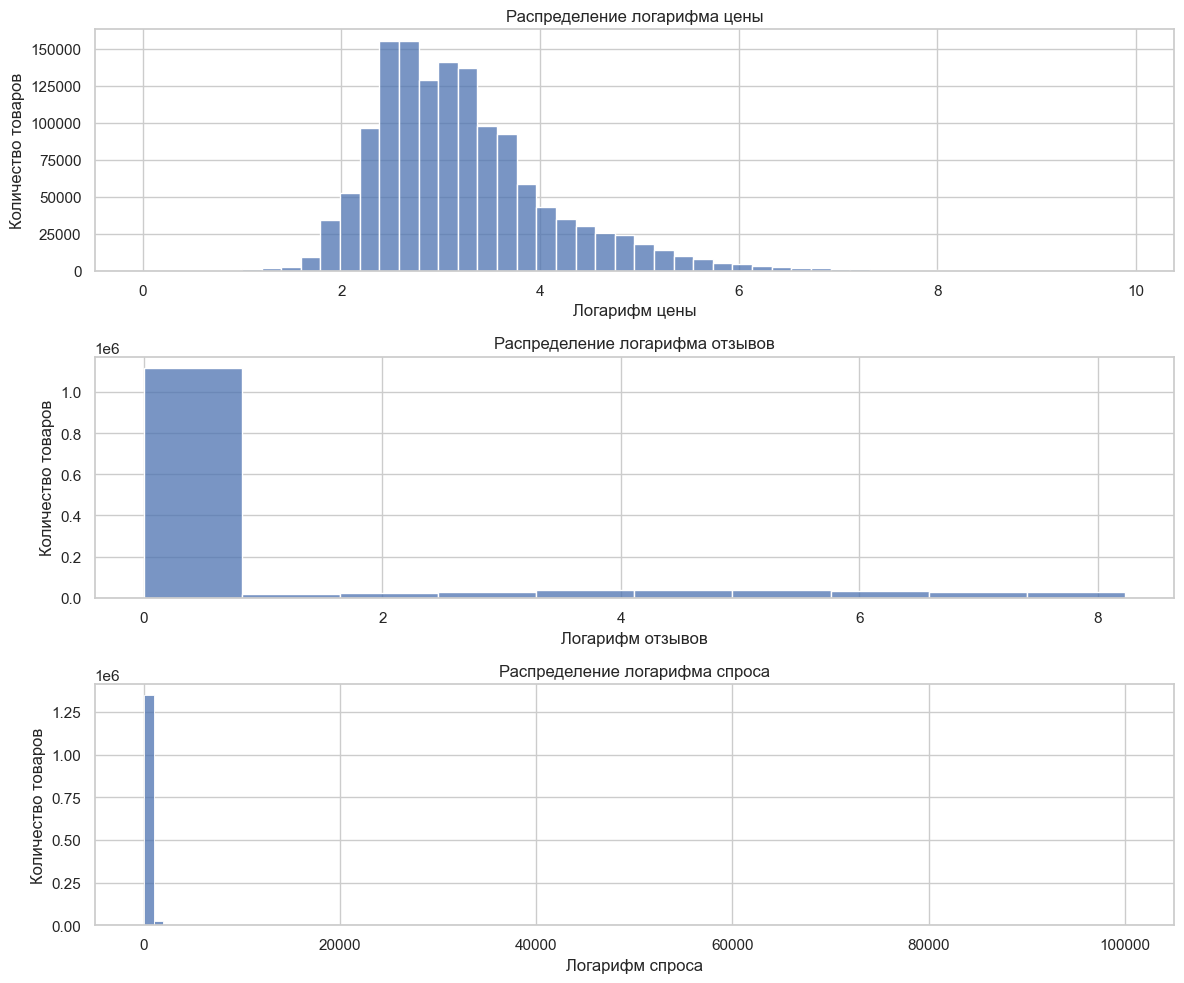

In [274]:
# визуализируем распределение логарифма цены
fig, axs = plt.subplots(3, figsize=(12, 10))
sns.histplot(data=df, x='log_price', bins=50, kde=False, ax=axs[0])
axs[0].set_title('Распределение логарифма цены')
axs[0].set_xlabel('Логарифм цены')
axs[0].set_ylabel('Количество товаров')
sns.histplot(data=df, x='reviews_log', bins=10, kde=False, ax=axs[1])
axs[1].set_title('Распределение логарифма отзывов')
axs[1].set_xlabel('Логарифм отзывов')
axs[1].set_ylabel('Количество товаров')
sns.histplot(data=df, x='boughtInLastMonth', bins=100, kde=False, ax=axs[2])
axs[2].set_title('Распределение логарифма спроса')
axs[2].set_xlabel('Логарифм спроса')
axs[2].set_ylabel('Количество товаров')
plt.tight_layout()
plt.show()

После логарифмирования распределение цен становится более симметричным и близким к колоколообразному, что отражает концентрацию товаров в среднем ценовом сегменте. При этом сохраняются умеренные хвосты распределения, указывающие на наличие как очень дешёвых, так и премиальных товаров.

Логарифмирование показателей количества отзывов и спроса позволило снизить влияние экстремальных значений, однако эти метрики по-прежнему характеризуются правосторонней асимметрией и выраженным эффектом длинного "хвоста". Это необходимо учитывать при интерпретации результатов анализа и при построении модели.

## 3. Анализ различий между бестселлерами и небестселлерами
Для выявления факторов, связанных со статусом Бестселлера, проведем сравнительный анализ характеристик товаров 
в группах бестселлеров и небестселлеров по ключевым метрикам: цене, скидке, рейтингу и количеству отзывов.

In [277]:
# добавим лейбл Бестселлер/Не-бестселлер
df['isBestSeller'] = df['isBestSeller'].fillna(0).astype(int)
df['isBestSeller_label'] = df['isBestSeller'].map({0: 'Не бестселлер', 1: 'Бестселлер'})

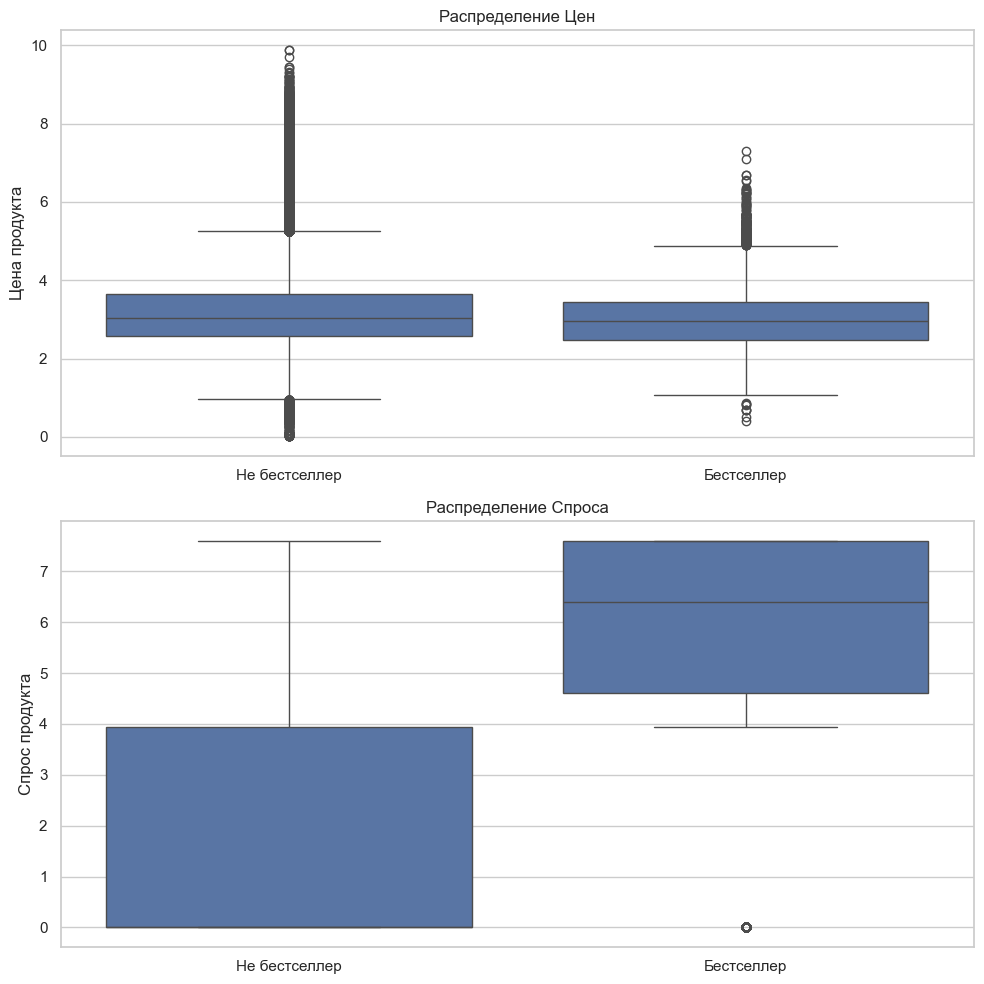

In [278]:
# визуализируем распределение логарифма цен и спроса продуктов Бестселлеров/Не-бестселлеров
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.boxplot(x='isBestSeller_label', y='log_price', data=df, ax=axs[0])
axs[0].set_title('Распределение Цен')
axs[0].set_ylabel('Цена продукта')
axs[0].set_xlabel('')
sns.boxplot(x='isBestSeller_label', y='log_sales', data=df, ax=axs[1])
axs[1].set_title('Распределение Спроса')
axs[1].set_ylabel('Спрос продукта')
axs[1].set_xlabel('')
plt.tight_layout()
plt.show()

Бестселлеры в среднем характеризуются более высоким спросом, при этом ценовой диапазон пересекается с небестселлерами.

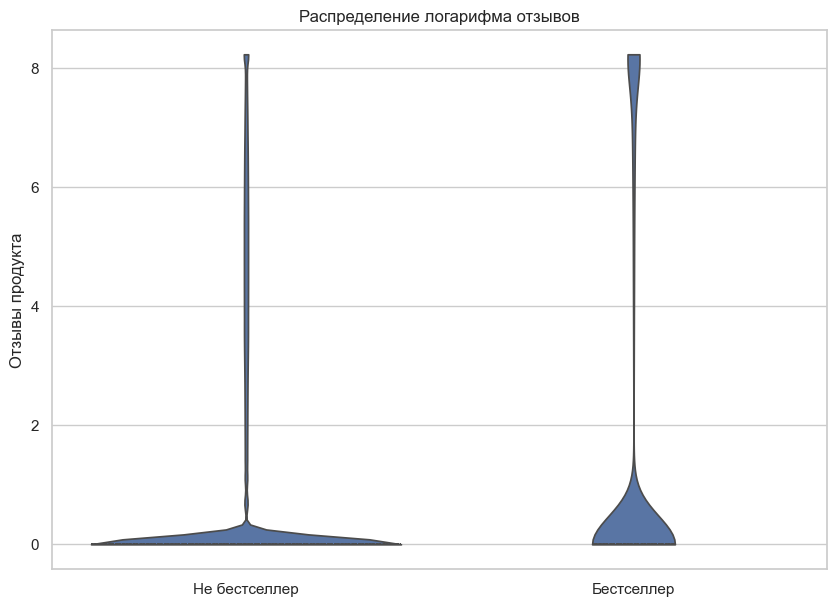

In [280]:
# визуализируем распределение логарифма отзывов
sns.violinplot(x='isBestSeller_label', y='reviews_log', data=df, inner='quartile', cut=0)
plt.ylabel('Отзывы продукта')
plt.xlabel('')
plt.title('Распределение логарифма отзывов')
plt.show()

Распределение логарифма количества отзывов для бестселлеров смещено вправо и имеет более длинный "хвост", что указывает на то, что бестселлеры имеют значительно большее количество отзывов по сравнению с небестселлерами.

Для подтверждения различий между бестселлерами и небестселлерами по ключевым метрикам применим непараметрический тест Манна–Уитни, так как распределения признаков не являются нормальными.

Гипотезы для критерия Манна–Уитни:
* H0 — распределения значений признака для бестселлеров и небестселлеров не различаются.
* Н1 — распределения значений признака для бестселлеров и небестселлеров различаются.

In [283]:
def mann_whitney_test(df, column, label_column='isBestSeller_label'):
    stat, p = mannwhitneyu(
        df[df[label_column] == "Бестселлер"][column],
        df[df[label_column] == "Не бестселлер"][column]
    )
    return p

In [284]:
for column in ['stars', 'reviews_log', 'log_sales', 'log_price']:
    p = mann_whitney_test(df, column)
    print(f'{column}: p-value = {p:.5f}, '
          f'{"Отклоняем H0" if p < 0.05 else "Не отклоняем H0"}')

stars: p-value = 0.00000, Отклоняем H0
reviews_log: p-value = 0.51812, Не отклоняем H0
log_sales: p-value = 0.00000, Отклоняем H0
log_price: p-value = 0.00000, Отклоняем H0


Тест показал, что распределения рейтинга, цен и продаж статистически значимо различаются, тогда как количество отзывов не демонстрирует значимых различий.

Расчитаем долю снижения цены относительно исходной стоимости - Discount. Скидка показывает относительное снижение price по сравнению с listPrice и измеряется в долях: 0.2 соответствует скидке 20%.

In [287]:
# расчитаем долю снижения цены относительно исходной стоимости
df['discount'] = np.where(df['listPrice'] > 0, (df['listPrice'] - df['price']) / df['listPrice'], np.nan)

In [288]:
# посмотрим чем бестселлер отличается от обычного товара по цене, скидке, рейтингу, количеству отзывов и покупок
df.groupby('isBestSeller').agg({
    'price': 'median',
    'discount': 'median',
    'stars': 'median',
    'reviews': 'mean',
    'boughtInLastMonth': 'median'
})

,price,discount,stars,reviews,boughtInLastMonth
isBestSeller,,,,,
0,19.99,0.170631,4.4,166.448736,0.0
1,18.49,0.240072,4.6,2328.392372,600.0


Типичный бестселлер стоит чуть дешевле, имеет скидку 24%, рейтинг 4.6 и в 14 раз больше отзывов , чем обычный товар.

In [290]:
# посотрим на статсистику продаж продуктов-бестселлеров и обычных товаров
df.groupby('isBestSeller')['boughtInLastMonth'].describe()

,count,mean,std,min,25%,50%,75%,max
isBestSeller,,,,,,,,
0,1385096.0,130.386125,671.648356,0.0,0.0,0.0,50.0,100000.0
1,8469.0,2335.677176,6179.404731,0.0,100.0,600.0,2000.0,100000.0


Как видим большинство обычных товаров практически не приносят продаж, в то время как бестселлеры гарантируют стабильный и высокий спрос.

## 4. Потроение модели
Для оценки факторов, связанных со статусом бестселлера построим модель бинарной классификации на основе логистической регрессии. Модель позволяет интерпретировать влияние цены, скидки и пользовательских метрик на вероятность того, что товар является бестселлером.
Характеристики модели:
* целевая переменная - "isBestSeller" (target)
* для прогнозирования используюем следущие признаки (numerical): 'log_price' (цена), 'discount' (скидка), 'stars' (рейтинг), 'reviews_log'(количество отзывов).
Перед обучением логистической регрессии все непрерывные признаки нормализуем с помощью StandardScaler, чтобы обеспечить сопоставимость коэффициентов модели и повысить стабильность обучения при различных масштабах признаков.


In [293]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

features = ['log_price', 'discount', 'reviews_log', 'stars']
X = df[features].fillna(0)
y = df['isBestSeller']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])  # Для предотвращения утечки данных и корректной нормализации признаков - масштабирование и обучение модели объединены в Pipeline

model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, pred_proba)

roc_auc # вероятность того, что модель даст бестселлеру более высокий скор, чем обычному товару



0.6881147463308057

Используя только цену, скидку, отзывы и рейтинг, мы можем с вероятностью 68,8% отличить бестселлер от обычного товара.

In [295]:
# таблица важности признаков для модели логистической регрессии.
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.named_steps['logreg'].coef_[0]
}).sort_values(by='Coefficient', ascending=False)
coef_df

,Feature,Coefficient
3,stars,0.865204
1,discount,0.361875
2,reviews_log,0.104191
0,log_price,-0.167773


In [296]:
# посмотрим на отношение шансов (odds ratio) для коэффициентов логистической регрессии
coef_df.assign(
    odds_ratio = np.exp(coef_df['Coefficient'])
)

,Feature,Coefficient,odds_ratio
3,stars,0.865204,2.375490
1,discount,0.361875,1.436019
2,reviews_log,0.104191,1.109813
0,log_price,-0.167773,0.845546


Интерпретация коэффициентов логистической регрессии показывает:
* Пользовательский рейтинг оказывает наибольшее влияние на вероятность попадания товара в категорию Bestseller (isBestSeller): увеличение рейтинга на одно стандартное отклонение повышает шансы стать бестселлером примерно в 2,4 раза.  
* Размер скидки положительно влияет на вероятность попадания товара в категорию Bestseller, однако его эффект уступает влиянию рейтинга: увеличение размера скидки на одно стандартное отклонение повышает шансы попасть в бестселлеры примерно на 44%. 
* Количество отзывов оказывает слабое, но положительное влияние: рост показателя отзывов на одно стандартное отклонение увеличивает вероятность попадания в бестселлеры всего на 11%.
* Цена товара оказывает отрицательное влияние: рост цены cнижает вероятность попадания товара в бестселлеры примерно на 15,5%.


Построенная модель имеет ряд ограничений:

* В датасете нет информации о динамике продаж во времени, поэтому модель не может использоваться для прогнозирования спроса. Полученные результаты отражают исключительно статические различия между товарами на момент наблюдения.

* Переменная "isBestSeller" является прокси-метрикой - статус бестселлера используется как упрощенная метрика успешности товара, однако он может не отражать реальный объём продаж.

* В данных отсутствует информация о других потенциально значимых факторах - маркетинговых активностях, бренде, сезонности, наличии внешнего трафика, рекламных кампаний, которые могут существенно влиять на продажи товара.

* Выявленные зависимости между характеристиками товара и статусом бестселлера требуют дополнительной проверки с использованием экспериментальных методов или временных данных.

### Выводы
Разработанная модель бинарной классификации показала:
* Рейтинг является наиболее значимым фактором, влияющим на вероятность попадания товара в бестселлеры.
* Скидка и количество отзывов положительно связаны со спросом, но играют вторичную роль по сравнению с пользовательским рейтингом.
* Более высокая цена снижает вероятность попадания товара в бестселлеры.
* Продажи и количество отзывов имеют выраженное асимметричное распределение: большинство товаров характеризуются низким спросом и малым числом отзывов, в то время как небольшая часть товаров формирует основную долю продаж и отзывов.





### Рекомендации
На основе результатов анализа и построенной модели можно предложить следующие практические рекомендации:
* Поддерживать высокий пользовательский рейтинг продукта (не ниже 4.5), так как рейтинг является наиболее важным фактором попадания в категорию бестселлров;
* Использовать умеренные скидки (в диапазоне 10-30%) как дополнительный инструмент стимулирования спроса;
* Стимулировать сбор отзывов, усиливая доверие состороны покупателей;
* Регулярно мониторить ключевые метрики (цена, скидка, рейтинг, количество отзывов) в динамике и использовать модель для раннего выявления товаров с высоким потенциалом стать бестселлерами, а также для приоритизации товаров в продвижении.